<a href="https://colab.research.google.com/github/sunshineluyao/eip1559-congestion/blob/main/Data_Analysis_Machine_Learning_for_Predicting_Market_Congestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**References**:


*   Computing Platforms: Set up the Workspace for Machine Learning Projects.  https://ms.pubpub.org/pub/computing
*  Machine Learning for Predictions. https://ms.pubpub.org/pub/ml-prediction
* Machine Learning Packages: https://scikit-learn.org/stable/



# Import and Inspect Data

In [192]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [193]:
plt.style.use('classic')
random.seed(42)

In [194]:
train_data = pd.read_csv('https://raw.githubusercontent.com/sunshineluyao/eip1559-congestion/main/data/processed_data/train.csv',index_col="Unnamed: 0")
test_data = pd.read_csv('https://raw.githubusercontent.com/sunshineluyao/eip1559-congestion/main/data/processed_data/test.csv',index_col="Unnamed: 0")

In [195]:
train_data.head()

,theta,congested,theta_ma_prev
99,0.996102,True,0.501285
100,0.000000,False,0.500021
101,0.102343,False,0.491051
102,0.999522,True,0.491049
103,0.999353,True,0.491049


In [196]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52776 entries, 99 to 52874
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   theta          52776 non-null  float64
 1   congested      52776 non-null  bool   
 2   theta_ma_prev  52776 non-null  float64
dtypes: bool(1), float64(2)
memory usage: 1.3 MB


In [197]:
test_data.head()

,theta,congested,theta_ma_prev
52974,0.103485,False,0.514615
52975,0.588646,False,0.510520
52976,0.033932,False,0.509132
52977,0.446000,False,0.503597
52978,0.259224,False,0.506189


In [198]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10476 entries, 52974 to 63449
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   theta          10476 non-null  float64
 1   congested      10476 non-null  bool   
 2   theta_ma_prev  10476 non-null  float64
dtypes: bool(1), float64(2)
memory usage: 255.8 KB


#The Rule of Thumb Algorithm

In [98]:
MA_WINDOW = 10

In [99]:
test_data['congested']

52974    False
52975    False
52976    False
52977    False
52978    False
         ...  
63445     True
63446     True
63447    False
63448    False
63449    False
Name: congested, Length: 10476, dtype: bool

In [100]:
pre_theta=test_data['congested'].shift(1) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html
pre_theta

52974      NaN
52975    False
52976    False
52977    False
52978    False
         ...  
63445    False
63446     True
63447     True
63448    False
63449    False
Name: congested, Length: 10476, dtype: object

In [101]:
prev_theta = test_data['congested'].shift(1)
congested_count = prev_theta.rolling(window=MA_WINDOW).sum().dropna()

y_pred = congested_count >= 5
y_true = test_data.loc[y_pred.index]['congested']

In [102]:
#alternative methods to define y_pred
congested_mean = test_data['congested'].shift(1).rolling(window=MA_WINDOW).mean().dropna()

In [103]:
congested_mean

52984    0.2
52985    0.2
52986    0.3
52987    0.3
52988    0.3
        ... 
63445    0.3
63446    0.4
63447    0.5
63448    0.4
63449    0.4
Name: congested, Length: 10466, dtype: float64

In [104]:
y_pred2 = congested_mean>=0.5

In [105]:
pd.DataFrame(y_pred).tail()

,congested
63445,False
63446,False
63447,True
63448,False
63449,False


In [106]:
pd.DataFrame(y_pred2).tail()

,congested
63445,False
63446,False
63447,True
63448,False
63449,False


In [107]:
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [108]:
# this class is only for performance benchmark
class NaiveAlgorithm(BaseEstimator):
    def __init__(self, y_pred):
        self.y_pred = y_pred
        self._estimator_type = 'classifier'
        
    def fit(self, X, y):
        pass

    def predict(self, X):
        return self.y_pred.loc[X].values.astype(int)
    

In [109]:
mdl = NaiveAlgorithm(y_pred=y_pred)

In [110]:
X_test = y_true.index.values

In [111]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.97      0.88      8435
        True       0.16      0.03      0.04      2031

    accuracy                           0.79     10466
   macro avg       0.48      0.50      0.46     10466
weighted avg       0.68      0.79      0.72     10466



In [112]:
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


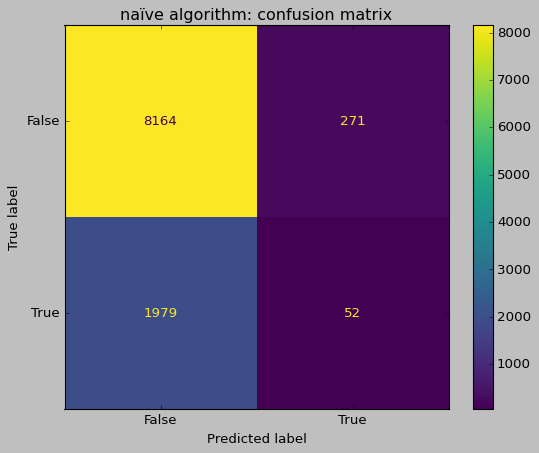

In [113]:
fig, ax = plt.subplots()
plot_confusion_matrix(mdl, X_test, y_true, ax=ax)
ax.set_title('naïve algorithm: confusion matrix')
fig.show()

# Machine Learning Classifier

## Define the Train and Test (X,y)

In [199]:
train_data.head()

,theta,congested,theta_ma_prev
99,0.996102,True,0.501285
100,0.000000,False,0.500021
101,0.102343,False,0.491051
102,0.999522,True,0.491049
103,0.999353,True,0.491049


In [200]:
X_train = pd.DataFrame(np.array(train_data['theta_ma_prev'].astype(float)).reshape(-1,1))
y_train = pd.DataFrame(train_data['congested'].astype(int))

In [201]:
test_data.head()

,theta,congested,theta_ma_prev
52974,0.103485,False,0.514615
52975,0.588646,False,0.510520
52976,0.033932,False,0.509132
52977,0.446000,False,0.503597
52978,0.259224,False,0.506189


In [203]:
X_test = pd.DataFrame(np.array(test_data['theta_ma_prev'].astype(float)).reshape(-1,1))
y_test = pd.DataFrame(test_data['congested'].astype(int))

## Decision Tree Classifer

### Model

In [204]:
from sklearn.tree import DecisionTreeClassifier

In [205]:
mdl = DecisionTreeClassifier().fit(X_train, y_train)

## Result

In [216]:
y_pred= mdl.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### Evaluations

In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      8443
           1       0.20      0.18      0.19      2033

    accuracy                           0.70     10476
   macro avg       0.50      0.50      0.50     10476
weighted avg       0.69      0.70      0.69     10476



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


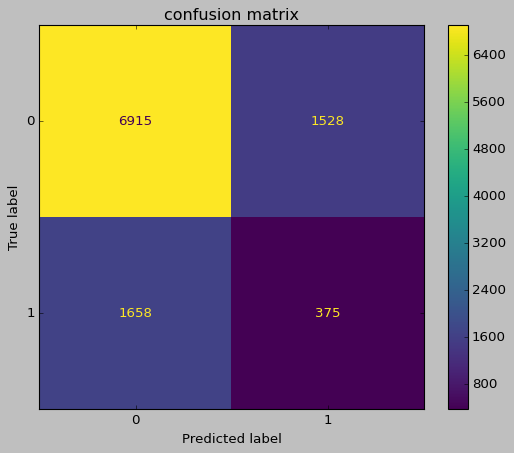

In [129]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

In [40]:
from sklearn.metrics import plot_roc_curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


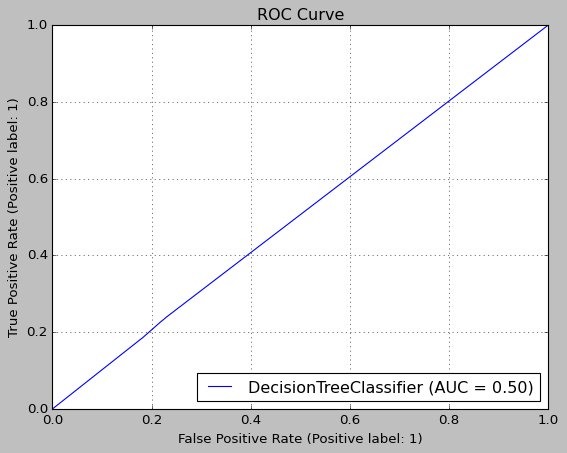

In [41]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
mdl = RandomForestClassifier().fit(X_train, y_train)

In [40]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      8443
           1       0.20      0.20      0.20      2033

    accuracy                           0.69     10476
   macro avg       0.50      0.50      0.50     10476
weighted avg       0.69      0.69      0.69     10476



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


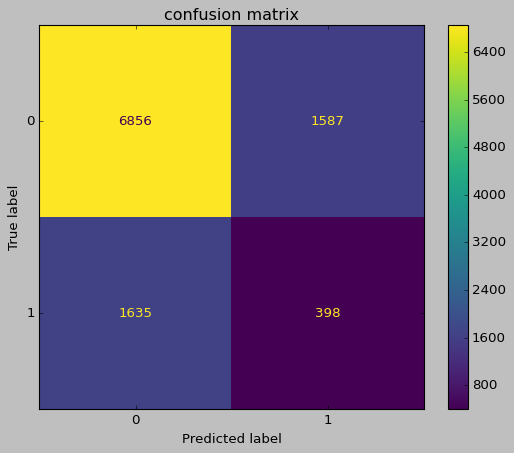

In [41]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


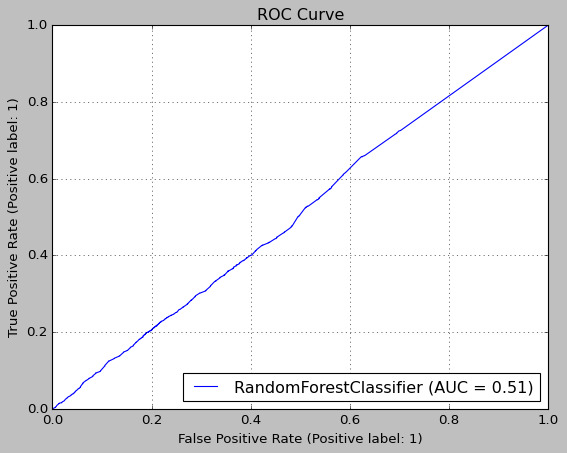

In [42]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## Multi-Layer Classifier

In [43]:
from sklearn.neural_network import MLPClassifier

In [44]:
mdl = MLPClassifier(hidden_layer_sizes=256).fit(X_train, y_train)

In [45]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      8443
           1       0.00      0.00      0.00      2033

    accuracy                           0.81     10476
   macro avg       0.40      0.50      0.45     10476
weighted avg       0.65      0.81      0.72     10476



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


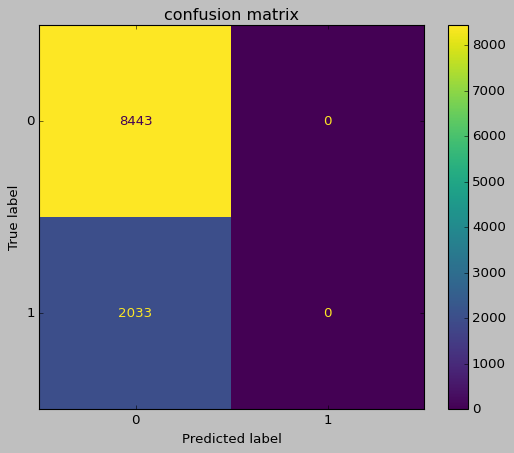

In [46]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

## Auto-ML Classifier

notes: 
* please first install the pacakge and restart run time 
* change runtime type to GPU can accelerate the speed
* after you restart the runtime, please mute the code box for package installation



In [1]:
!pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 4.5 MB/s 
     |████████████████████████████████| 62 kB 815 kB/s 
     |████████████████████████████████| 101 kB 14.5 MB/s 
     |████████████████████████████████| 279 kB 88.1 MB/s 
     |████████████████████████████████| 224 kB 84.1 MB/s 
     |████████████████████████████████| 49 kB 8.3 MB/s 
     |████████████████████████████████| 59 kB 8.5 MB/s 
     |████████████████████████████████| 802 kB 71.0 MB/s 
     |████████████████████████████████| 41 kB 524 kB/s 
     |████████████████████████████████| 132 kB 70.3 MB/s 
     |████████████████████████████████| 1.0 MB 68.8 MB/s 
     |████████████████████████████████| 60.5 MB 3.0 MB/s 
     |████████████████████████████████| 1.6 MB 77.8 MB/s 
     |████████████████████████████████| 280 kB 90.0 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 
     |████████████████████████████████| 54

In [3]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [42]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train.values

test_df = pd.DataFrame(X_test)
test_df['target'] = y_test.values

In [43]:
train_data = TabularDataset(train_df)
test_data = TabularDataset(test_df)

In [44]:
predictor = TabularPredictor(
    path='AutogluonModels/classifier',
    label='target'
).fit(train_data)

# predictor = TabularPredictor.load("AutogluonModels/classifier/")

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/classifier/"
AutoGluon Version:  0.6.0
Python Version:     3.7.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    52776
Train Data Columns: 1
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    87323.0 MB
	Train Data (Original)  Memory Usage: 0.42 MB (0.0% of available memory)
	Inferring data type of each feature base

In [115]:
predictor = TabularPredictor.load("AutogluonModels/classifier/")

In [116]:
predictor.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.7892       0.155539  40.367017                0.004438           1.274234            2       True         14
1       NeuralNetFastAI     0.7888       0.043174  39.070148                0.043174          39.070148            1       True         10
2              CatBoost     0.7876       0.005399   0.392628                0.005399           0.392628            1       True          7
3              LightGBM     0.7876       0.008159   0.174392                0.008159           0.174392            1       True          4
4            LightGBMXT     0.7876       0.008235   1.477655                0.008235           1.477655            1       True          3
5         LightGBMLarge     0.7876       0.008482   0.304839                0.008482           0.304839            1       True         13
6               XGBoost    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.7892,0.155539,40.367017,0.004438,1.274234,2,True,14
1,NeuralNetFastAI,0.7888,0.043174,39.070148,0.043174,39.070148,1,True,10
2,CatBoost,0.7876,0.005399,0.392628,0.005399,0.392628,1,True,7
3,LightGBM,0.7876,0.008159,0.174392,0.008159,0.174392,1,True,4
4,LightGBMXT,0.7876,0.008235,1.477655,0.008235,1.477655,1,True,3
5,LightGBMLarge,0.7876,0.008482,0.304839,0.008482,0.304839,1,True,13
6,XGBoost,0.7876,0.010299,0.121825,0.010299,0.121825,1,True,11
7,NeuralNetTorch,0.7876,0.022654,32.396092,0.022654,32.396092,1,True,12
8,KNeighborsUnif,0.7412,0.108789,0.025029,0.108789,0.025029,1,True,1
9,ExtraTreesGini,0.7172,0.207718,1.724769,0.207718,1.724769,1,True,8


In [151]:
r2 = r2_score(y_test,
              predictor.predict(
                  X_test)
              )
print(f'R2 Score: {r2}')

R2 Score: 0.016260676054903


# Regression

## Define the Train and Test (X, y)

In [168]:
train_data.head()

,theta,congested,theta_ma_prev
99,0.996102,True,0.501285
100,0.000000,False,0.500021
101,0.102343,False,0.491051
102,0.999522,True,0.491049
103,0.999353,True,0.491049


In [177]:
y_train = pd.DataFrame(train_data['theta'].astype(float))
X_train = pd.DataFrame(train_data['theta_ma_prev'].astype(float))

In [170]:
test_data.head()

,theta,congested,theta_ma_prev
52974,0.103485,False,0.514615
52975,0.588646,False,0.510520
52976,0.033932,False,0.509132
52977,0.446000,False,0.503597
52978,0.259224,False,0.506189


In [187]:
y_test = pd.DataFrame(test_data['theta'].astype(float))
X_test = pd.DataFrame(test_data['theta_ma_prev'].astype(float))

# Linear Regression

In [182]:
from sklearn import linear_model

In [188]:
mdl = linear_model.LinearRegression().fit(X_train,y_train)

In [189]:
# calculate R2
from sklearn.metrics import r2_score

In [191]:
r2 = r2_score(y_test, mdl.predict(X_test))
print(f'R2 Score: {r2}')


R2 Score: 0.01650656454202082


## Random Forest Regression

In [117]:
from sklearn.ensemble import RandomForestRegressor

In [140]:
mdl = RandomForestRegressor().fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [141]:
# calculate R2
from sklearn.metrics import r2_score

In [143]:
r2 = r2_score(y_test, mdl.predict(X_test))
print(f'R2 Score: {r2}')


R2 Score: -0.4311598551669633


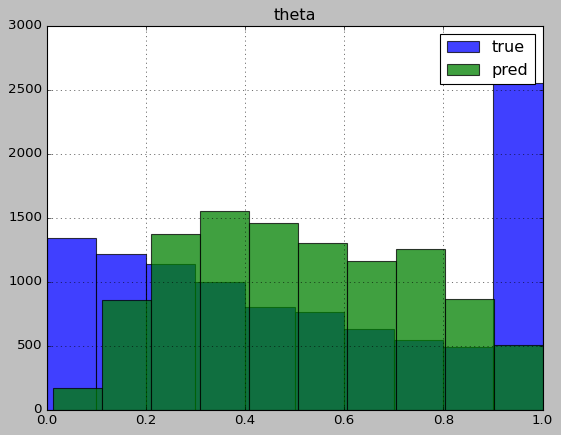

In [144]:
fig, ax = plt.subplots()

y_test.hist(ax=ax, label='true', alpha=.75)
pd.Series(mdl.predict(X_test)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


# Auto-ML

In [145]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train.values

test_df = pd.DataFrame(X_test)
test_df['target'] = y_test.values

In [146]:
train_data = TabularDataset(train_df)
test_data = TabularDataset(test_df)

In [147]:
predictor = TabularPredictor(
    path='AutogluonModels/regression/',
    label='target'
).fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/regression/"
AutoGluon Version:  0.6.0
Python Version:     3.7.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    52776
Train Data Columns: 1
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.0, 0.0, 0.51466, 0.34308)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    86573.92 MB
	Train Data (Original)  Memory Usage: 0.42 MB (0.0% of available memory)
	Inferring data type of eac

In [148]:
predictor = TabularPredictor.load("AutogluonModels/regression/")

In [149]:
predictor.leaderboard(test_data)

                  model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       NeuralNetFastAI   -0.340006  -0.341746        0.195555       0.038672  44.860728                 0.195555                0.038672          44.860728            1       True          8
1            LightGBMXT   -0.340100  -0.341698        0.011149       0.023878   0.248275                 0.011149                0.023878           0.248275            1       True          3
2              CatBoost   -0.340274  -0.341587        0.042323       0.002394   1.380827                 0.042323                0.002394           1.380827            1       True          6
3               XGBoost   -0.340319  -0.341769        0.026951       0.004975   0.138156                 0.026951                0.004975           0.138156            1       True          9
4   WeightedEnsemble_L2   -0.340392  -0.

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI,-0.340006,-0.341746,0.195555,0.038672,44.860728,0.195555,0.038672,44.860728,1,True,8
1,LightGBMXT,-0.340100,-0.341698,0.011149,0.023878,0.248275,0.011149,0.023878,0.248275,1,True,3
2,CatBoost,-0.340274,-0.341587,0.042323,0.002394,1.380827,0.042323,0.002394,1.380827,1,True,6
3,XGBoost,-0.340319,-0.341769,0.026951,0.004975,0.138156,0.026951,0.004975,0.138156,1,True,9
4,WeightedEnsemble_L2,-0.340392,-0.341458,0.986762,0.272941,48.405108,0.004230,0.000651,0.443872,2,True,12
5,LightGBM,-0.340464,-0.341636,0.006705,0.023129,0.270194,0.006705,0.023129,0.270194,1,True,4
6,LightGBMLarge,-0.340912,-0.341881,0.028274,0.004128,0.511924,0.028274,0.004128,0.511924,1,True,11
7,NeuralNetTorch,-0.341547,-0.343675,0.066321,0.019160,56.148890,0.066321,0.019160,56.148890,1,True,10
8,ExtraTreesMSE,-0.358387,-0.356077,0.632117,0.104036,1.426466,0.632117,0.104036,1.426466,1,True,7
9,KNeighborsUnif,-0.373427,-0.372453,0.105427,0.104019,0.023109,0.105427,0.104019,0.023109,1,True,1


In [152]:
r2 = r2_score(y_test,
              predictor.predict(
                  X_test)
              )
print(f'R2 Score: {r2}')

R2 Score: 0.016260676054903


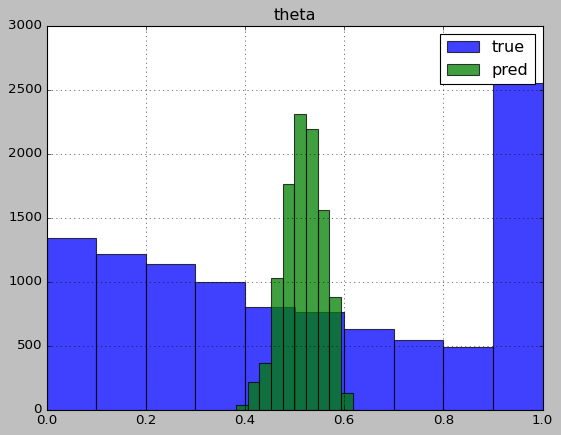

In [154]:
fig, ax = plt.subplots()

y_test.hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(X_test)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()
